
# Towards Dynamic Mode Decomposition 

# and Port-Hamiltonian Systems in pyMOR

## Jonas Nicodemus

### pyMOR School 2022

### August 25, 2022



# Get the slides

<img src="figures/qr_gh_slides.png" width="30%"/>

[https://github.com/Jonas-Nicodemus/phdmd-pymor-school-22](https://github.com/Jonas-Nicodemus/phdmd-pymor-school-22)

# System identification

<div>
    <center>
        <img src="figures/si.svg" width="50%"/>
    </center>
</div>


## My favorite academic toy example

<div>
    <center>
        <img src="figures/msd.svg" width="70%"/>
    </center>
</div>


# (io)DMD

<div>
    <center>
       <img src="figures/dmd.svg" width="40%"/>
    </center>
</div>

## Least squares

$$
\begin{align*}
    \min_{A,B,C,D} \sum_{i=0}^{M-1} \|x_{i+1} - Ax_i + Bu_i\|^2_2 + \|y_i - Cx_i + Du_i\|^2_2
\end{align*} 
$$


## Matrix formulation

$$
\begin{align*}
    \min_{
        \mathcal{A}
    } 
    \bigg\|\underbrace{
        \begin{bmatrix}
            x_1 & \ldots & x_{M}\\
            y_0 & \ldots & y_{M-1}
        \end{bmatrix}}_{=: Z} - 
    \underbrace{
        \begin{bmatrix}
            A & B\\
            C & D
        \end{bmatrix}
    }_{=: \mathcal{A}}
    \underbrace{
        \begin{bmatrix}
            x_0 & \ldots & x_{M-1}\\
            u_0 & \ldots & u_{M-1}
        \end{bmatrix}
    }_{=: T}
    \bigg\|_{\mathrm{F}}
         , \quad\rightsquigarrow
         \mathcal{A}^\star = ZT^\dagger
\end{align*}
$$


# An alternative discrete LTI model



<!-- ## Implicit Midpoint Method -->

<div>
    <center>
       <img src="figures/imp.svg" width="40%"/>
    </center>
</div>

\begin{align*}
    x_{i+1} &= x_{i} + \delta f(t_i + \frac{\delta}{2}, \frac{x_{i+1} + x_{i}}{2})\\
\end{align*}

\begin{align*}
    \frac{x_{i+1}-x_{i}}{\delta} &= f(t_i + \frac{\delta}{2}, \frac{x_{i+1} + x_{i}}{2}) = A\frac{x_{i+1} + x_{i}}{2} + B\frac{u_{i+1} + u_{i}}{2}\\
\end{align*}

\begin{align*}
    \frac{x_{i+1}-x_{i}}{\delta} &= A\frac{x_{i+1} + x_{i}}{2} + B\frac{u_{i+1} + u_{i}}{2}\\
\end{align*}

\begin{align*}
    \frac{y_{i+1}+y_{i}}{2} &= C\frac{x_{i+1} + x_{i}}{2} + D\frac{u_{i+1} + u_{i}}{2}\\
\end{align*}

# Roadmap

- generate the data
- transform the data
- fit the data
- evaluate


# Generate data


In [1]:
import sys
import logging

import numpy as np

import pymor
from pymor.algorithms.to_matrix import to_matrix

# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../src')

from utils.plotting import trajectories_plot

# pymor.config

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


## The true model

<div>
    <center>
        <img src="figures/msd.svg" width="70%"/>
    </center>
</div>

In [2]:
from model.msd import msd

n = 6 # state dimension
m = 1 # input dimension = output dimension

A, B, C, Q = msd(n, m, m_i=4, k_i=4, c_i=1)

In [3]:
from pymor.models.iosys import LTIModel

lti = LTIModel.from_matrices(A, B, C)
lti 

LTIModel(
    NumpyMatrixOperator(<6x6 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<6x1 dense>, range_id='STATE'),
    NumpyMatrixOperator(<1x6 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(1), NumpyVectorSpace(1)),
    E=IdentityOperator(NumpyVectorSpace(6, id='STATE')),
    presets={})


## Simulate


In [4]:
N = 100
T_end = 4
T_train = np.linspace(0, T_end, N) # time interval
delta = T_train[1] - T_train[0] # step size

x0_train = np.zeros(n) # initial condition
u_train = lambda t: np.exp(-0.5 * t) * np.sin(t ** 2) # control signal

In [7]:
from discretization.discretization import sim

U_train, X_train, Y_train = sim(lti, u_train, T_train, x0_train) # via implicit midpoint rule
X_train.shape

(6, 100)

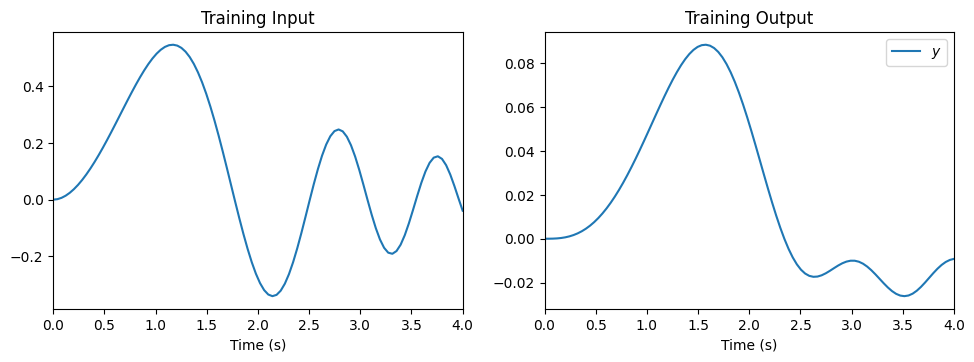

In [8]:
trajectories_plot(T_train, U_train, Y_train)


# Transform the data

\begin{align*}
    \frac{x_{i+1}-x_{i}}{\delta} &= A\frac{x_{i+1} + x_{i}}{2} + B\frac{u_{i+1} + u_{i}}{2}\\
    \frac{y_{i+1}+y_{i}}{2} &= C\frac{x_{i+1} + x_{i}}{2} + D\frac{u_{i+1} + u_{i}}{2}\\
\end{align*}


In [9]:
W = (X_train[:, 1:] - X_train[:, :-1]) / delta
V = 1 / 2 * (X_train[:, 1:] + X_train[:, :-1])
U = 1 / 2 * (U_train[:, 1:] + U_train[:, :-1])
Y = 1 / 2 * (Y_train[:, 1:] + Y_train[:, :-1])

T = np.concatenate((V, U))
Z = np.concatenate((W, Y))
Z.shape

(7, 99)


# Fit the data

$$
\begin{align*}
    \min_{
        \mathcal{A}
    } 
    \bigg\|\underbrace{
        \begin{bmatrix}
            \frac{x_{1}-x_{0}}{\delta} & \ldots & \frac{x_{M}-x_{M-1}}{\delta}\\
            \frac{y_{1}+y_{0}}{2} & \ldots & \frac{y_{M}+y_{M-1}}{2}
        \end{bmatrix}}_{=: Z} - 
    \underbrace{
        \begin{bmatrix}
            A & B\\
            C & D
        \end{bmatrix}
    }_{=: \mathcal{A}}
    \underbrace{
        \begin{bmatrix}
            \frac{x_{1} + x_{0}}{2} & \ldots & \frac{x_{M} + x_{M-1}}{2}\\
            \frac{u_{1} + u_{0}}{2} & \ldots & \frac{u_{M} + u_{M-1}}{2}
        \end{bmatrix}
    }_{=: T}
    \bigg\|_{\mathrm{F}}
         , \rightsquigarrow
         \mathcal{A}^\star = ZT^\dagger
\end{align*}
$$

In [10]:
def iodmd(Z, T):
    
    A = Z @ np.linalg.pinv(T)

    return A

AA = iodmd(Z, T)

In [11]:
e = np.linalg.norm(Z - AA @ T)/np.linalg.norm(Z)

print(f'Relative error: {e:.2e}')

Relative error: 6.14e-14



## DMD in pyMOR


In [12]:
from pymor.algorithms.dmd import dmd
from pymor.vectorarrays.numpy import NumpyVectorSpace

Zva = NumpyVectorSpace.from_numpy(Z.T)
Tva = NumpyVectorSpace.from_numpy(T.T)

_, _, AA = dmd(Tva, Zva, svd_method='qr_svd', return_A_approx=True)

AA = to_matrix(AA)

03:11 dmd: SVD of X ...
03:11 qr_svd: Computing QR decomposition ...
03:11 |   gram_schmidt: Orthonormalizing vector 1 again
03:11 |   gram_schmidt: Orthonormalizing vector 2 again
03:11 |   gram_schmidt: Orthonormalizing vector 3 again
03:11 |   gram_schmidt: Orthonormalizing vector 4 again
03:11 |   gram_schmidt: Orthonormalizing vector 5 again
03:11 |   gram_schmidt: Orthonormalizing vector 6 again
03:11 |   gram_schmidt: Removing linearly dependent vector 7
03:11 |   gram_schmidt: Removing linearly dependent vector 8
03:11 |   gram_schmidt: Removing linearly dependent vector 9
03:11 |   gram_schmidt: Removing linearly dependent vector 10
03:11 |   gram_schmidt: Removing linearly dependent vector 11
03:11 |   gram_schmidt: Removing linearly dependent vector 12
03:11 |   gram_schmidt: Removing linearly dependent vector 13
03:11 |   gram_schmidt: Removing linearly dependent vector 14
03:11 |   gram_schmidt: Removing linearly dependent vector 15
03:11 |   gram_schmidt: Removing linearl

In [13]:
e = np.linalg.norm(Z - AA @ T)/np.linalg.norm(Z)

print(f'Relative error: {e:.2e}')

Relative error: 2.15e-15


In [14]:
A = AA[:n, :n]
B = AA[:n, n:]
C = AA[n:, :n]
D = AA[n:, n:]

lti_dmd = LTIModel.from_matrices(A, B, C, D)
lti_dmd

LTIModel(
    NumpyMatrixOperator(<6x6 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<6x1 dense>, range_id='STATE'),
    NumpyMatrixOperator(<1x6 dense>, source_id='STATE'),
    D=NumpyMatrixOperator(<1x1 dense>),
    E=IdentityOperator(NumpyVectorSpace(6, id='STATE')),
    presets={})


# Evaluate


In [ ]:
from utils.plotting import magnitude_plot

def evaluate(lti, lti_dmd):
    lti_error = lti - lti_dmd # error lti system

    h2 = lti_error.h2_norm()
    h2_rel = h2 / lti.h2_norm()
    print(f'Relative H2 error: {h2_rel:.2e}')

    hinf = lti_error.hinf_norm()
    hinf_rel = hinf / lti.hinf_norm()
    print(f'Relative Hinf error: {hinf_rel:.2e}')

    w = np.logspace(-1, 3, 1000)
    magnitude_plot(w, lti_error)

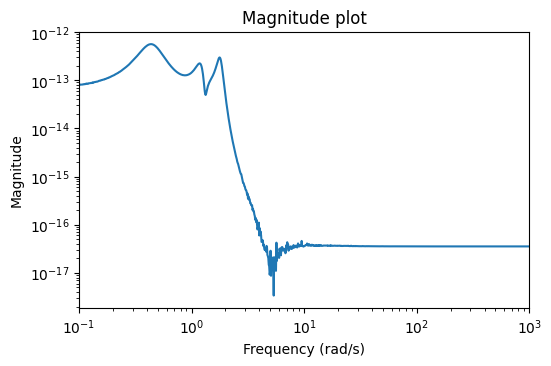

In [15]:
from utils.plotting import magnitude_plot

w = np.logspace(-1, 3, 1000)
lti_error = lti - lti_dmd
magnitude_plot(w, lti_error)


## Simulate for a testing input signal


In [16]:
from scipy.signal import sawtooth

T_test = np.linspace(0, 10, 1000) # testing time interval
freq = 0.5  # Hz
u_test = lambda t: sawtooth(2 * np.pi * freq * t) # testing input signal

x0_test = 10 * np.ones(n) # testing initial condition

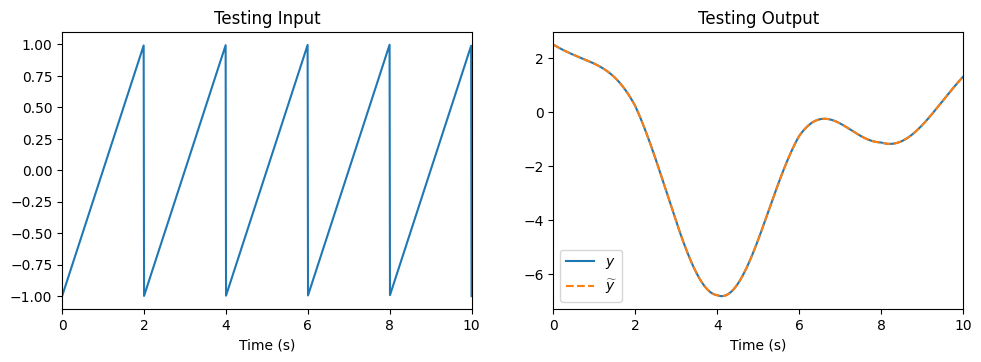

In [17]:
U_test, X_test, Y_test = sim(lti, u_test, T_test, x0_test)
U_dmd, X_dmd, Y_dmd = sim(lti_dmd, u_test, T_test,x0_test)

trajectories_plot(T_test, U_test, Y_test, Y_dmd)


# Is the identified model close to the real physical system?



## Passivity
\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}H(x(t)) &\leq \langle y(t),u(t)\rangle
\end{align*}


with storage function

\begin{align*}
    H(x(t)) := \tfrac{1}{2} x(t)^\top Q x(t) & \qquad\mathrm{with}\qquad Q=Q^\top\ge0
\end{align*}

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}H(x(t)) = \tfrac{1}{2} x(t)^\top Q \dot{x}(t)
\end{align*}

In [18]:
def change_hamiltonian(lti, X, U, Q=None):
    X = X.T
    dHdt = np.zeros((1, len(X)))
    
    for i, x in enumerate(X):
        Edxdt = to_matrix(lti.A) @ x + to_matrix(lti.B) @ U_dmd[:,i]
        if Q is not None:
            dHdt[0, i] = x.T @ Q @ Edxdt
        else:
            dHdt[0, i] = x.T @ Edxdt
    
    return dHdt

\begin{align*}
    \langle y(t),u(t)\rangle
\end{align*}

In [19]:
def supply_rate(Y, U):
    return Y * U


## Is the identified system passive?

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}H(x(t)) &\leq \langle y(t),u(t)\rangle
\end{align*}

In [20]:
from utils.plotting import passivity_plot

def is_passive(lti, T, X, Y, U, Q=None):
    S = supply_rate(Y, U)
    dHdt = change_hamiltonian(lti, X, U, Q)
    passivity_plot(T, dHdt, S) # plot dHdt - S <= 0
    return np.all(np.less_equal(dHdt, S)) # check if dissipation inequality is satisfied for theese trajectories

True

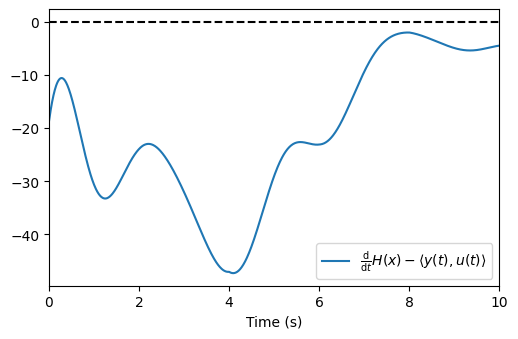

In [21]:
is_passive(lti_dmd, T_test, X_dmd, Y_dmd, U_dmd, Q) 


# A second true model

<div>
    <center>
        <img src="figures/msd-no-damping.svg" width="70%"/>
    </center>
</div>

In [22]:
n = 6 # state dimension
m = 1 # input dimension = output dimension

A, B, C, Q = msd(n, m, m_i=4, k_i=4, c_i=1e-12)

lti = LTIModel.from_matrices(A, B, C)


## Repeat the roadmap


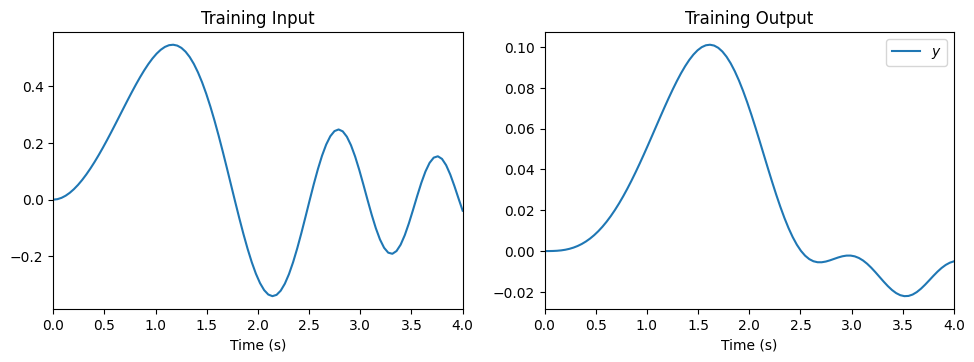

In [23]:
U_train, X_train, Y_train = sim(lti, u_train, T_train, x0_train) # via implicit midpoint rule

trajectories_plot(T_train, U_train, Y_train)

W = (X_train[:, 1:] - X_train[:, :-1]) / delta
V = 1 / 2 * (X_train[:, 1:] + X_train[:, :-1])
U = 1 / 2 * (U_train[:, 1:] + U_train[:, :-1])
Y = 1 / 2 * (Y_train[:, 1:] + Y_train[:, :-1])

T = np.concatenate((V, U))
Z = np.concatenate((W, Y))


## Fit the data


In [24]:
Zva = NumpyVectorSpace.from_numpy(Z.T)
Tva = NumpyVectorSpace.from_numpy(T.T)

_, _, AA = dmd(Tva, Zva, svd_method='qr_svd', return_A_approx=True)

AA = to_matrix(AA)

04:19 dmd: SVD of X ...
04:19 qr_svd: Computing QR decomposition ...
04:19 |   gram_schmidt: Orthonormalizing vector 1 again
04:19 |   gram_schmidt: Orthonormalizing vector 2 again
04:19 |   gram_schmidt: Orthonormalizing vector 3 again
04:19 |   gram_schmidt: Orthonormalizing vector 4 again
04:19 |   gram_schmidt: Orthonormalizing vector 5 again
04:19 |   gram_schmidt: Orthonormalizing vector 6 again
04:19 |   gram_schmidt: Removing linearly dependent vector 7
04:19 |   gram_schmidt: Removing linearly dependent vector 8
04:19 |   gram_schmidt: Removing linearly dependent vector 9
04:19 |   gram_schmidt: Removing linearly dependent vector 10
04:19 |   gram_schmidt: Removing linearly dependent vector 11
04:19 |   gram_schmidt: Removing linearly dependent vector 12
04:19 |   gram_schmidt: Removing linearly dependent vector 13
04:19 |   gram_schmidt: Removing linearly dependent vector 14
04:19 |   gram_schmidt: Removing linearly dependent vector 15
04:19 |   gram_schmidt: Removing linearl


## Evaluate

Relative error: 2.16e-15


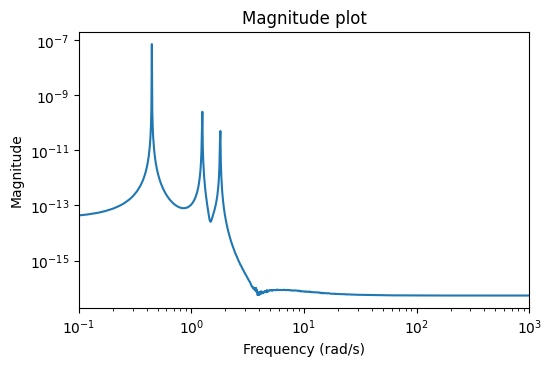

In [25]:
e = np.linalg.norm(Z - AA @ T)/np.linalg.norm(Z)

print(f'Relative error: {e:.2e}')

A = AA[:n, :n]
B = AA[:n, n:]
C = AA[n:, :n]
D = AA[n:, n:]

lti_dmd = LTIModel.from_matrices(A, B, C, D)

w = np.logspace(-1, 3, 1000)
lti_error = lti - lti_dmd
magnitude_plot(w, lti_error)

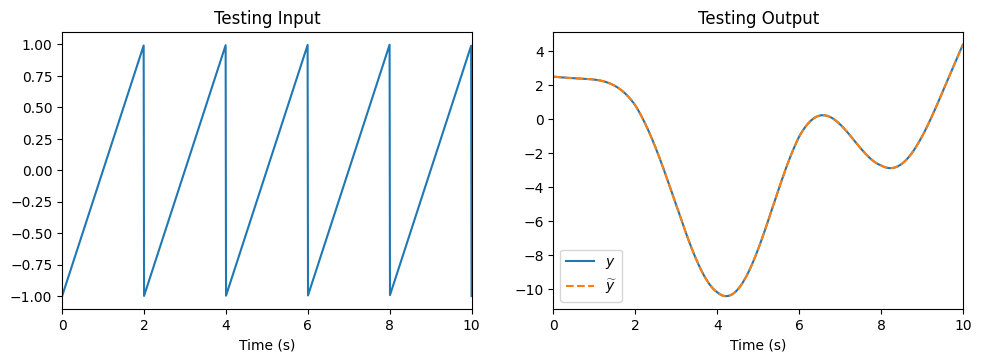

In [26]:
U_test, X_test, Y_test = sim(lti, u_test, T_test, x0_test)
U_dmd, X_dmd, Y_dmd = sim(lti_dmd, u_test, T_test, x0_test)


trajectories_plot(T_test, U_test, Y_test, Y_dmd)


## Still passive?


False

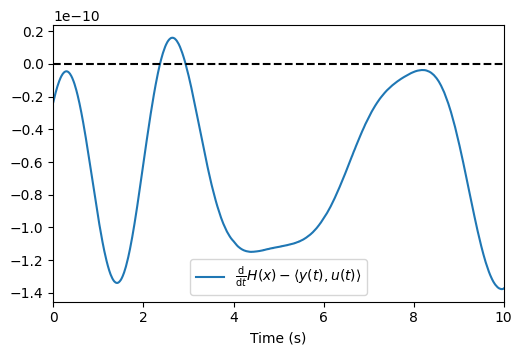

In [27]:
is_passive(lti_dmd, T_test, X_dmd, Y_dmd, U_dmd, Q)

# Is ABCD the right choice?

# A (part of a) modelling wish list

- system theoretic approach
- energy/exergy/entropy
- open/closed systems 
- close to physics

## Port-Hamiltonian system

\begin{align*}
    \dot{x}(t) &= (J-R)\nabla H(x(t)) + (G-P)u(t),\\
    y(t) &= (G+P)^\top \nabla H(x(t)) + (S-N)u(t)
\end{align*}

with 

- Hamiltonian (energy)

\begin{align*}
    H(x(t)) := \tfrac{1}{2} x(t)^\top Q x(t)
\end{align*}

- Structure matrix

\begin{align*}
    \mathcal{J} := \begin{bmatrix}\phantom{-}J & G\\ -G^\top & N\end{bmatrix} = -\mathcal{J}^\top
\end{align*}

- Dissipation matrix

\begin{align*}
    \mathcal{R} := \begin{bmatrix}R & P\\ P^\top & S\end{bmatrix} = \mathcal{R}^\top \ge 0
\end{align*}




## Port-Hamiltonian implies passivity

\begin{align*}
    Q\dot{x}(t) &= (J-R) x(t) + (G-P)u(t),\\
    y(t) &= (G+P)^\top x(t) + (S-N)u(t)
\end{align*}

Dissipation inequality

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}H(x(t)) &\leq \langle y(t),u(t)\rangle
\end{align*}

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}H(x) &= x^\top Q \dot{x} 
        = x^\top (J-R) x + x^\top(G-P)u - y^\top u + y^\top u\\
        &= -x^\top R x + x^\top (G-P) u - x^\top (G+P) u - u^\top S u + y^\top u\\
        &= - \begin{bmatrix}x \\ u\end{bmatrix}^\top \underbrace{\begin{bmatrix}R & P\\ P^\top & S\end{bmatrix}}_{:=\mathcal{R}\ge0} \begin{bmatrix}x \\ u\end{bmatrix} + y^\top u \le y^\top u
 \end{align*} 


# The pHDMD problem

\begin{align*}
    \min_{\mathcal{J}, \mathcal{R}} \bigg\| 
    \underbrace{\begin{bmatrix}Q W \\ -Y \end{bmatrix}}_{=:Z} 
    - \bigg(\underbrace{\begin{bmatrix}J & G \\ -G^\top & N \end{bmatrix}}_{=:\mathcal{J}}
    - \underbrace{\begin{bmatrix}R & P \\ P^\top & S \end{bmatrix}}_{=:\mathcal{R}}
    \bigg)
    \underbrace{\begin{bmatrix}V \\ U \end{bmatrix}}_{=:T} \bigg\|_{\mathrm{F}} \qquad\text{s.t. $\mathcal{J} = -\mathcal{J}^\top$ and $\mathcal{R}\geq 0$}
\end{align*}


\begin{align*}
    &\min_{\mathcal{J}=-\mathcal{J}^\top} \|Z - (\mathcal{J} - \mathcal{R}) T\|_{\mathrm{F}} 
    & &\min_{\mathcal{R} \ge 0} \|Z - (\mathcal{J} - \mathcal{R}) T\|_{\mathrm{F}} \\
    =&\min_{\mathcal{J}=-\mathcal{J}^\top} \|\underbrace{Z + \mathcal{R} T}_{=: Z_1} - \mathcal{J} T\|_\mathrm{F} 
    & =&\min_{\mathcal{R} \ge 0} \|\underbrace{-Z + \mathcal{J} T}_{=: Z_2} - \mathcal{R} T\|_{\mathrm{F}}\\
    & \text{$\rightsquigarrow$ analytical solution available} & & \text{$\rightsquigarrow$ algorithmic solution available}
\end{align*}


# The pHDMD algorithm

<div>
    <center>
        <img src="figures/phdmd.svg" width="70%"/>
    </center>
</div>

In [30]:
from algorithm.phdmd import phdmd_FGM

Z = np.concatenate((Q @ W, -Y))
T = np.concatenate((V, U))

J0 = np.zeros((n + m, n + m))
R0 = np.eye(n + m) # naive initialization

J, R, e = phdmd_FGM(T, Z, J0, R0, max_iter=20)

INFO:root:|Z - (J^(0) - R^(0) T|_F / |Z|_F=1.44e+00
INFO:root:|Z - (J^(1) - R^(1) T|_F / |Z|_F=4.13e-01
INFO:root:|Z - (J^(2) - R^(2) T|_F / |Z|_F=1.92e-01
INFO:root:|Z - (J^(3) - R^(3) T|_F / |Z|_F=1.26e-01
INFO:root:|Z - (J^(4) - R^(4) T|_F / |Z|_F=1.05e-01
INFO:root:|Z - (J^(5) - R^(5) T|_F / |Z|_F=8.34e-02
INFO:root:|Z - (J^(6) - R^(6) T|_F / |Z|_F=6.16e-02
INFO:root:|Z - (J^(7) - R^(7) T|_F / |Z|_F=4.15e-02
INFO:root:|Z - (J^(8) - R^(8) T|_F / |Z|_F=2.54e-02
INFO:root:|Z - (J^(9) - R^(9) T|_F / |Z|_F=1.92e-02
INFO:root:|Z - (J^(10) - R^(10) T|_F / |Z|_F=1.91e-02
INFO:root:|Z - (J^(11) - R^(11) T|_F / |Z|_F=1.90e-02
INFO:root:|Z - (J^(12) - R^(12) T|_F / |Z|_F=1.89e-02
INFO:root:|Z - (J^(13) - R^(13) T|_F / |Z|_F=1.89e-02
INFO:root:|Z - (J^(14) - R^(14) T|_F / |Z|_F=1.88e-02
INFO:root:|Z - (J^(15) - R^(15) T|_F / |Z|_F=1.87e-02
INFO:root:|Z - (J^(16) - R^(16) T|_F / |Z|_F=1.86e-02
INFO:root:|Z - (J^(17) - R^(17) T|_F / |Z|_F=1.85e-02
INFO:root:|Z - (J^(18) - R^(18) T|_F / |Z|_F=1.8


## Initialization

We know the analyitcal solution of
\begin{align*}\|T^\top Z - T^\top (\mathcal{J} - \mathcal{R}) T\|_{\mathrm{F}}\qquad\text{s.t. $\mathcal{J} = -\mathcal{J}^\top$ and $\mathcal{R}\geq 0$}.\end{align*}

Let $V\Sigma W^\top = T$. 

Define

\begin{align*}\widetilde{Z}:=\Sigma V^\top Z W\end{align*}

then

\begin{align*}
    \mathcal{J}^\star := V\Sigma^{-1} \mathrm{skew}(\widetilde{Z})\Sigma^{-1}V^\top \qquad\text{and}\qquad
    \mathcal{R}^\star := V\Sigma^{-1}\mathcal{P}_{\ge}(-\widetilde{Z})\Sigma^{-1} V^\top.
\end{align*}


# pHDMD with initialization


In [31]:
from algorithm.phdmd import init_phdmd

J0, R0 = init_phdmd(T, Z)
J, R, e = phdmd_FGM(T, Z, J0, R0, max_iter=20)

INFO:root:|Z - (J^(0) - R^(0) T|_F / |Z|_F=2.81e-14
INFO:root:|Z - (J^(1) - R^(1) T|_F / |Z|_F=1.35e-14
INFO:root:Converged after 1 iterations.


In [32]:
P = R[:n, n:]
S = R[n:, n:]

G = J[:n, n:]
N = J[n:, n:]

R = R[:n, :n]
J = J[:n, :n]

In [33]:
from pymor.models.iosys import PHLTIModel

phlti_phdmd = PHLTIModel.from_matrices(J, R, G, P, S, N, Q) # PHLTIModel is already supported in pyMOR!
phlti_phdmd

PHLTIModel(
    NumpyMatrixOperator(<6x6 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<6x6 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<6x1 dense>, range_id='STATE'),
    P=NumpyMatrixOperator(<6x1 dense>, range_id='STATE'),
    S=NumpyMatrixOperator(<1x1 dense>),
    N=NumpyMatrixOperator(<1x1 dense>),
    E=NumpyMatrixOperator(<6x6 dense>, source_id='STATE', range_id='STATE'))


## Evaluate the pH system


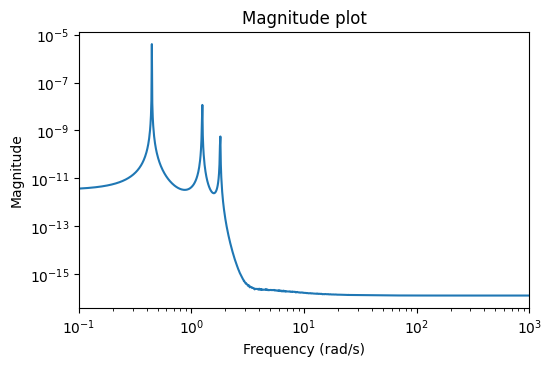

In [34]:
w = np.logspace(-1, 3, 1000)
lti_error = lti - phlti_phdmd # LTIModel - PHLTIModel is supported!
magnitude_plot(w, lti_error)

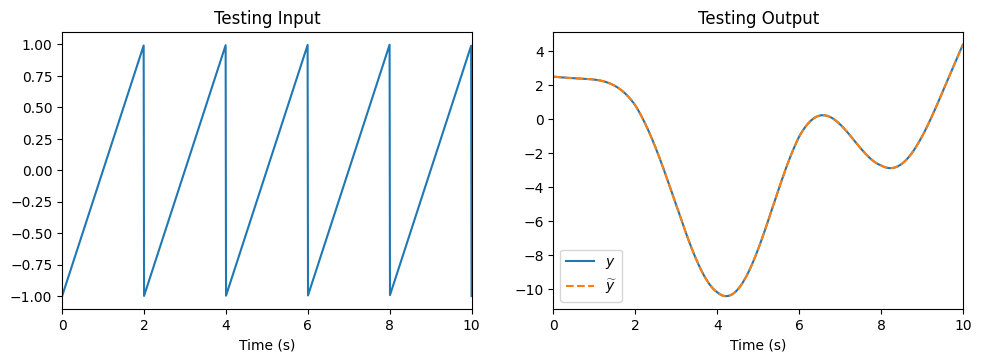

In [35]:
U_phdmd, X_phdmd, Y_phdmd = sim(phlti_phdmd.to_lti(), u_test, T_test, x0_test)

trajectories_plot(T_test, U_test, Y_test, Y_phdmd)


## Passivity is guaranteed


True

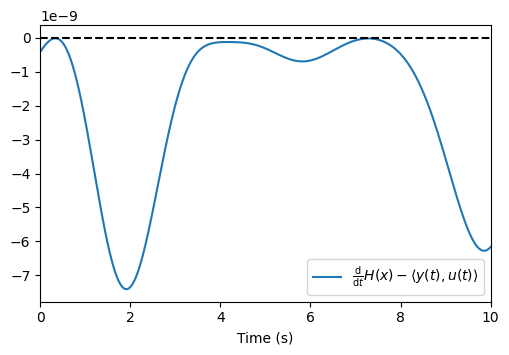

In [36]:
is_passive(phlti_phdmd.to_lti(), T_test, X_phdmd, Y_phdmd, U_phdmd)

## Take home message
    - Structure (preserving) comes with costs but provides guarantees

## Upcoming work
    - Structure preserving MOR in pyMOR

<img src="figures/qr_gh_phdmd.png" width="30%"/>

[https://github.com/Jonas-Nicodemus/phdmd](https://github.com/Jonas-Nicodemus/phdmd)